# Player/item embeddings in job space
Natalia Vélez, July 2020

In [1]:
%matplotlib inline

import os,re,glob
import numpy as np
import pandas as pd

import scipy.cluster
import sklearn.metrics
import sklearn.cluster

import matplotlib.pyplot as plt
import seaborn as sns

import ohol_objects as obj

from tqdm import notebook

sns.set_style('white')
sns.set_context('talk')

Map change files:

In [2]:
map_files = glob.glob('outputs/maplog/*.tsv')
map_files.sort()
print(*map_files[:10], sep='\n')

outputs/maplog/maplog_release-284_start-1573895672.tsv
outputs/maplog/maplog_release-284_start-1573982073.tsv
outputs/maplog/maplog_release-284_start-1574068473.tsv
outputs/maplog/maplog_release-285_start-1574102503.tsv
outputs/maplog/maplog_release-287_start-1574151678.tsv
outputs/maplog/maplog_release-287_start-1574238079.tsv
outputs/maplog/maplog_release-287_start-1574324479.tsv
outputs/maplog/maplog_release-287_start-1574410879.tsv
outputs/maplog/maplog_release-287_start-1574497279.tsv
outputs/maplog/maplog_release-289_start-1574552311.tsv


Load SVD outputs:

In [3]:
Vh_hat = np.loadtxt('outputs/svd/Vh_hat.txt')
print('Vh_hat: %s' % (Vh_hat.shape,))

Vh_hat: (238, 2805)


## Item embeddings

### Tally most common items

In [5]:
df_list = []
for f in notebook.tqdm(map_files):
    df = pd.read_csv(f, sep='\t')

    # Clean up modifiers
    df['object_id'] = df.object_id.str.replace(r'^(f)|([u-v][0-9]+$)', '')

    # Convert to number
    df['object_id'] = df['object_id'].astype(np.int64)
    df['object_id'] = np.where(df['object_id'] > 5000, 9999, df['object_id'])

    # Filter valid player events
    df = df[(df['object_id'] > 0) & (df['player_id'] > 0)]

    # Sum # occurrences
    df = df.groupby('object_id')['player_id'].agg('count').reset_index()
    
    # Add to list
    df_list.append(df)

Concatenate and combine:

In [6]:
item_df = pd.concat(df_list)
item_df = item_df.rename(columns={'player_id': 'count'})
item_df = item_df.groupby('object_id')['count'].agg('sum').reset_index()
item_df['freq'] = item_df['count']/np.sum(item_df['count'])
item_df['log_freq'] = np.log(item_df['freq'])
item_df = item_df.sort_values('freq', ascending=False).reset_index(drop=True)
item_df.head()

,object_id,count,freq,log_freq
0,292,6195351,0.046072,-3.077551
1,391,5413350,0.040257,-3.212482
2,235,4904982,0.036476,-3.311098
3,253,3906360,0.029050,-3.538744
4,1099,2906245,0.021612,-3.834488


Distribution of item frequencies:

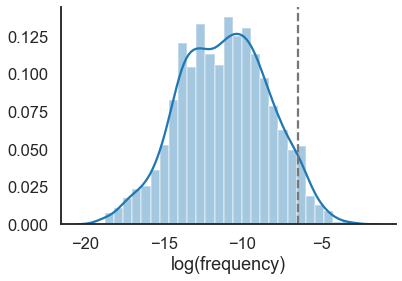

In [7]:
freq_tresh = np.quantile(item_df['log_freq'], .95)
ax = sns.distplot(item_df['log_freq'])
ax.set(xlabel = 'log(frequency)')
plt.axvline(freq_tresh, color='#777777', linestyle='--')
sns.despine()

Get 20% most frequent items:

In [8]:
pop_df = item_df[item_df['log_freq'] >= freq_tresh].reset_index(drop=True)
pop_summ = pop_df['count'].agg(['max', 'min'])
popular_items = pop_df.object_id.values
print('Selecting %i most popular items' % len(popular_items))
print('(%i - % i uses)' % (pop_summ['min'], pop_summ['max']))
print(*['%i: %s' % (i, obj.obj_name(i)) for i in popular_items[:50]], sep='\n')
print('...')

Selecting 141 most popular items
(213780 -  6195351 uses)
292: Basket
391: Domestic Gooseberry Bush
235: Clay Bowl - empty
253: Bowl of Gooseberries - +yum31
1099: Partial Bucket of Water
30: Wild Gooseberry Bush
34: Sharp Stone
1101: Fertile Soil Pile
236: Clay Plate
3161: Escaped Horse-Drawn Tire Cart - just released
33: Stone
1603: Stack of Clay Bowls
484: Hand Cart
1602: Stack of Clay Plates
2742: Carrot Pile
72: Kindling
1138: Fertile Soil
67: Long Straight Shaft
1316: Stack of Firewood
213: Deep Tilled Row - groundOnly
107: Stakes - +tool
291: Flat Rock - empty
400: Carrot Row
135: Flint Chip
1136: Shallow Tilled Row - groundOnly +biomeBlock4
1135: Empty Domestic Gooseberry Bush
64: Straight Branch
393: Dry Domestic Gooseberry Bush
1134: Vigorous Domestic Gooseberry Bush
31: Gooseberry
198: Backpack
248: Firebrand
2172: Hand Cart with Tires
1599: Kindling Pile
55: Milkweed Debris -Fruit
346: Large Slow Fire
48: Maple Tree
486: Floor Stakes
344: Firewood
304: Firing Forge
250: Hot

### Find item clusters

Load object labels:

In [9]:
obj_labels = np.loadtxt('outputs/activity_features.txt').astype(np.int)
obj_labels

array([  30,   31,   32, ..., 4218, 4219, 9999])

Find indices of most popular items:

In [10]:
is_pop = np.isin(obj_labels, popular_items)
pop_idx = np.where(is_pop)[0]
len(pop_idx)

141

Filter Vh to get embeddings for most popular items only:

In [11]:
Vh = Vh_hat.T
Vh_pop = Vh[pop_idx,:]
Vh_pop.shape

(141, 238)

Pairwise distances (cosine distance):

In [13]:
Vh_dist = sklearn.metrics.pairwise_distances(Vh_pop, metric='cosine')
Vh_dist.shape

(141, 141)

Plot heatmap:

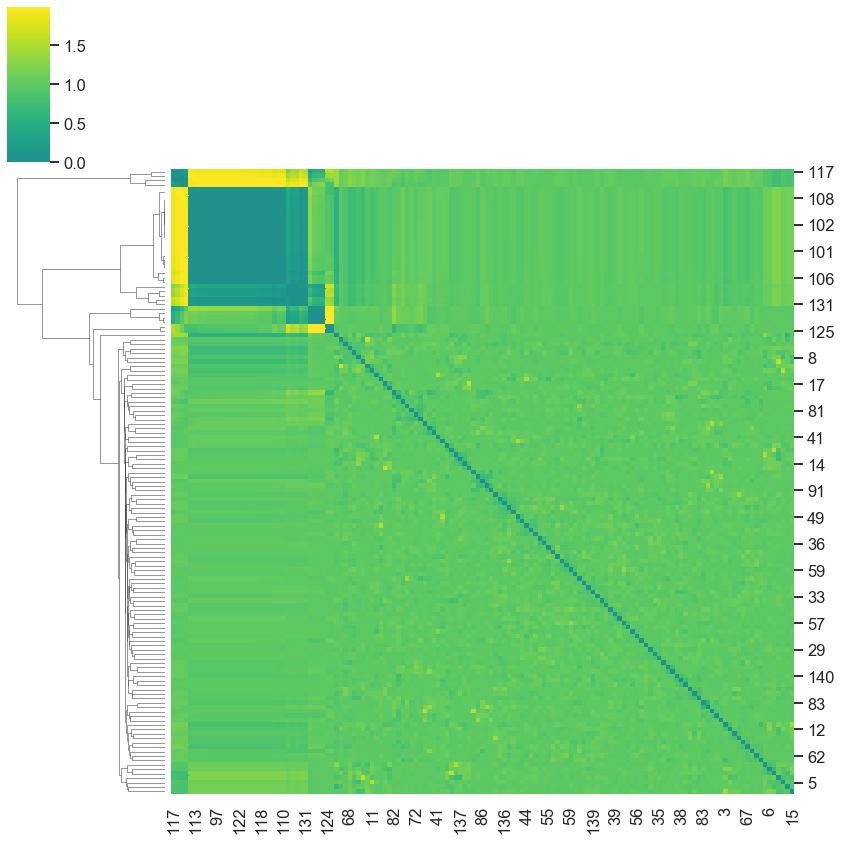

In [14]:
cg = sns.clustermap(Vh_dist, figsize=(12,12), cmap='viridis')
cg.ax_col_dendrogram.set_visible(False)
#cg.ax_row_dendrogram.set_visible(False)

Vector magnitudes:

In [ ]:
vec_lengths = np.linalg.norm(Vh, axis=1)
len(vec_lengths)

In [ ]:
sns.distplot(vec_lengths)

Create dendrogram

In [ ]:
dendro = sch.dendrogram(sch.linkage(Vh, method='ward'))

Perform clustering:

Whiten data (beneficial for clustering methods to have unit variance):

Detecting clusters:

In [ ]:
item_distances = np.corr(Vh)
print(item_distances.shape)
print(np.min(item_distances))
print(np.max(item_distances))

Clusterplot

In [ ]:
sns.clustermap(item_distances, center=0, cmap="vlag",
               linewidths=.75, figsize=(13, 13))